#### Checking the GPU (if any)

In [1]:
# !nvidia-smi -L

#### Imports

In [2]:
import torch
torch.cuda.empty_cache()

import time
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
import warnings
import pandas as pd

In [3]:
# Custom local imports
from src.dataloader import get_MELD_loaders
from src.parse import parse_opt
from src.trainer import build_model, trainer

In [4]:
# To ignore the warnings from sklearn.metrics.classification_report
warnings.filterwarnings("ignore") 

#### Prepare the arguments and data

In [5]:
args = parse_opt()
args.cuda = not args.no_cuda and torch.cuda.is_available()

{'attention': 'general',
 'batch_size': 30,
 'class_weight': False,
 'dir': './MELD_features/',
 'dropout': 0.2,
 'epochs': 100,
 'feature_type': 'audio',
 'l2': 0.0003,
 'loss_fn': 'masked_nll',
 'lr': 0.0001,
 'mu': 0,
 'n_classes': 7,
 'no_cuda': True,
 'num_workers': 0,
 'optimizer': 'sgd',
 'seed': 42,
 'val_split': 0,
 'verbose': True}


In [6]:
global D_m

if args.feature_type == 'text':
    print("Running on the text features........")
    D_m = 600
elif args.feature_type == 'audio':
    print("Running on the audio features........")
    D_m = 300
elif args.feature_type == 'multimodal':
    print("Running on the multimodal features........")
    D_m = 900
    
D_g = D_q = D_r = 150
D_h = D_e = 100

Running on the audio features........


In [7]:
model, optimizer, loss_function = build_model(D_m, D_q, D_g, D_r, D_e, D_h, args)

EmotionNet(
  (dropout): Dropout(p=0.2, inplace=False)
  (emo_rnn_b): EmotionRNN(
    (dropout): Dropout(p=0.2, inplace=False)
    (cell): EmotionGRUCell(
      (g_cell): GRUCell(600, 150)
      (p_cell): GRUCell(450, 150)
      (pl_cell): GRUCell(450, 150)
      (r_cell): GRUCell(450, 150)
      (rl_cell): GRUCell(450, 150)
      (e_cell): GRUCell(600, 100)
      (dropout): Dropout(p=0.2, inplace=False)
      (attention): MatchingAttention(
        (transform): Linear(in_features=300, out_features=150, bias=False)
      )
    )
  )
  (emo_rnn_f): EmotionRNN(
    (dropout): Dropout(p=0.2, inplace=False)
    (cell): EmotionGRUCell(
      (g_cell): GRUCell(600, 150)
      (p_cell): GRUCell(450, 150)
      (pl_cell): GRUCell(450, 150)
      (r_cell): GRUCell(450, 150)
      (rl_cell): GRUCell(450, 150)
      (e_cell): GRUCell(600, 100)
      (dropout): Dropout(p=0.2, inplace=False)
      (attention): MatchingAttention(
        (transform): Linear(in_features=300, out_features=150, bias=Fa

In [8]:
train_loader, valid_loader , test_loader = get_MELD_loaders(path = args.dir + 'MELD_features_raw.pkl',
                                                           n_classes=args.n_classes,
                                                           valid=args.val_split,
                                                           batch_size=args.batch_size,
                                                           num_workers=args.num_workers)

#### Training phase

In [9]:
model, metrics, best_label, best_pred, best_mask, best_attn, test_class_report = trainer(args=args, 
                                                                                         model=model, 
                                                                                         train_loader=train_loader, 
                                                                                         valid_loader=valid_loader, 
                                                                                         test_loader=test_loader, 
                                                                                         optimizer=optimizer, 
                                                                                         loss_function=loss_function)

Epoch	[1]	 Train Loss: 2.179	 Train Acc: 21.280%	 Train F1: 23.760	 Val Loss: nan	 Val Acc: nan%	 Val F1: nan	 Time: 33.52 sec 


KeyboardInterrupt: 

In [ ]:
train_losses = metrics['train']['train_losses']
train_fscores = metrics['train']['train_fscores']
train_accs = metrics['train']['train_accs']

val_losses = metrics['val']['val_losses']
val_fscores = metrics['val']['val_fscores']
val_accs = metrics['val']['val_accs']

test_losses = metrics['test']['test_losses']
test_fscores = metrics['test']['test_fscores']
test_accs = metrics['test']['test_accs']

best_fscore = metrics['best']['best_fscore']
best_loss = metrics['best']['best_loss']
best_acc = metrics['best']['best_acc']

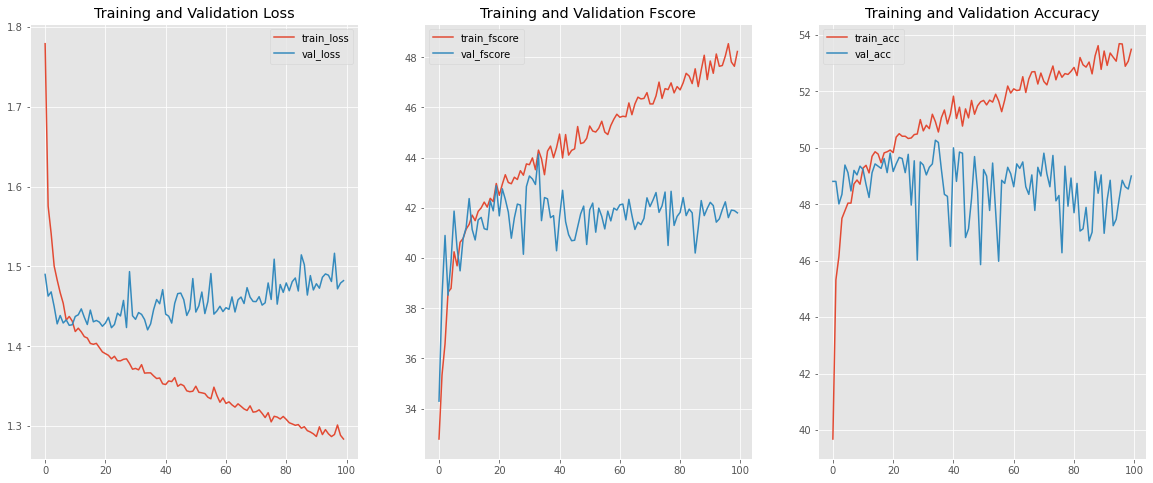

In [ ]:
# plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

plt.style.use("ggplot")

fig = plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='val_loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_fscores, label='train_fscore')
plt.plot(test_fscores, label='val_fscore')
plt.title('Training and Validation Fscore')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_accs, label='train_acc')
plt.plot(test_accs, label='val_acc')
plt.title('Training and Validation Accuracy')
plt.legend()

#### Testing phase

In [ ]:
print('[Metrics]\t', end='')
print('Fscore: {:.3f}\tLoss: {:.3f}\tAccuracy: {:.3f}%\n'.format(best_fscore, best_loss, accuracy_score(best_label,best_pred,sample_weight=best_mask)*100))

[Metrics]	Fscore: 44.140	Loss: 1.433	Accuracy: 49.425%



In [ ]:
print('\nClassification report:')
print(classification_report(best_label,best_pred,sample_weight=best_mask,digits=4))


Classification report:
              precision    recall  f1-score   support

           0     0.5663    0.8089    0.6662    1256.0
           1     0.3202    0.2598    0.2868     281.0
           2     0.0000    0.0000    0.0000      50.0
           3     0.5000    0.0577    0.1034     208.0
           4     0.3152    0.2015    0.2458     402.0
           5     0.0000    0.0000    0.0000      68.0
           6     0.3518    0.3130    0.3313     345.0

    accuracy                         0.4943    2610.0
   macro avg     0.2934    0.2344    0.2334    2610.0
weighted avg     0.4419    0.4943    0.4414    2610.0



In [ ]:
print('\nConfusion matrix:')
print(confusion_matrix(best_label,best_pred,sample_weight=best_mask))


Confusion matrix:
[[1.016e+03 6.900e+01 0.000e+00 9.000e+00 8.400e+01 0.000e+00 7.800e+01]
 [1.580e+02 7.300e+01 0.000e+00 0.000e+00 2.100e+01 0.000e+00 2.900e+01]
 [3.500e+01 2.000e+00 0.000e+00 0.000e+00 5.000e+00 0.000e+00 8.000e+00]
 [1.420e+02 2.100e+01 0.000e+00 1.200e+01 9.000e+00 0.000e+00 2.400e+01]
 [2.430e+02 3.400e+01 0.000e+00 3.000e+00 8.100e+01 0.000e+00 4.100e+01]
 [3.500e+01 1.000e+00 0.000e+00 0.000e+00 1.300e+01 0.000e+00 1.900e+01]
 [1.650e+02 2.800e+01 0.000e+00 0.000e+00 4.400e+01 0.000e+00 1.080e+02]]


#### Save model

'31-10'

In [ ]:
cur_date = time.strftime("%d-%m", time.localtime())
filename = "emotionet_model_"+cur_date+"_"+args.feature_type+"_"

AttributeError: 'Namespace' object has no attribute 'features'

In [ ]:
model_name = 'models/'+filename+str(int(round(best_fscore,0)))+'.pt'
torch.save(model.state_dict(), args.dir + model_name)
print('Model saved to {}.'.format(args.dir + model_name))

Model saved to models/EmoNet_44.pt.


In [ ]:
# Store all training metrics per epoch in a dataframe
train_metrics = pd.DataFrame(metrics['train'])
test_metrics = pd.DataFrame(metrics['test'])
val_metrics = pd.DataFrame(metrics['val'])
metrics = pd.concat([train_metrics, val_metrics, test_metrics], axis=1)
metrics.to_csv(args.dir + 'logs/'+ filename+ 'metrics.csv', index=False)
print('Metrics saved to {}.'.format(args.dir + 'logs/'+ filename+ 'metrics.csv'))

Metrics saved to ./MELD_features/logs/metrics.csv.
